# Jupyter notebook to reproduce some of the results of Chapter 3 of the thesis

In [13]:
import numpy as np
import scipy as sp
from scipy import linalg as scpal
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import itertools
from tqdm import tqdm
import matplotlib


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
def getspect(H):
    #Obtain sorted eigenvalues and corresponding eigenvectors of the Hamiltonian. 
    eig= scpal.eig(H, left=True)
    idx = eig[0].real.argsort()
    eigval = eig[0][idx]
    vl= eig[1][:,idx]
    vr= eig[2][:,idx]
    return (eigval, vl, vr)
 
def difsort(a,b):
    c = np.zeros(len(b),complex)
    for i in range(len(a)):
        dif = b - a[i]
        index = np.argmin(np.abs(dif))
        c[i] = b[index]
    return c
 
def HPBC_ODIS(v, g, w, L, phi, D, rand):
    H = np.zeros((2*L,2*L),dtype = complex)
    for i in range(L):
        H[L+i,i] = (v-g); 
        H[i,L+i] = (v+g);
        H[i,i] = D*rand[i]
        H[L+i,L+i] = D*rand[i] 
        if (i<L-1):
            H[L+i,i+1] = w*np.exp(-1j*phi/(1*L)); 
            H[i+1,L+i] = w*np.exp(+1j*phi/(1*L));
    H[0,2*L-1] = w*np.exp(+1j*phi/(1*L)); 
    H[2*L-1,0] = w*np.exp(-1j*phi/(1*L));     

    return H
 
def PBCNHSSHODIS(L,v,w,d,D):
    rand = np.zeros(2*L)
 
    for i in range(2*L):
        rand[i] = 2*(np.random.random() - 0.5)
 
    steps = 50
    phi = np.linspace(0,2*np.pi,steps)
    energy = np.zeros([steps,2*L],complex)
    dW = np.zeros(2*L)

    for i in range(steps):
        Ham = HPBC_ODIS(v,d,w,L,phi[i],D,rand)
        en = np.linalg.eigvals(Ham)
        if (i == 0):
            energy[i,:] = en
        if (i != 0):
            energy[i,:] = difsort(energy[i-1,:],en)
    for i in range(2*L):
        for k in range(steps-1):
            ddw = np.angle(energy[k+1,i]) - np.angle(energy[k,i])
            if (ddw > 1):
                ddw = ddw-2*np.pi
            if (ddw < -1):
                ddw = ddw + 2*np.pi
            dW[i] += ddw
    W = np.round(np.sum(dW)/(-2*np.pi))
    return W


## Calculating the numerical disorder averaging for the NHSSH model, 
$$    \mathcal{W}(E) = -\int_0^{2\pi} \frac{d \Phi}{2\pi i} \frac{d}{d \Phi} \text{log} \left\{ \text{det} \left[ H(\Phi) - E \right] \right\}$$
where the Hamiltonian is given by 

\begin{align}
    H(\Phi) = (v-g) \sum_{j=1}^N c^\dagger_{A,j} c_{B,j} + (v+g) \sum_{j=1}^N c^\dagger_{B,j} c_{A,j} 
    + w \sum_{j=1}^N \left( e^{+i(\Phi/N)} c^\dagger_{B,j} c_{A,j+1} + \text{h.c.}\right), \notag
\end{align}

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/it]


Text(0, 0.5, '$\\overline{\\mathcal{W}(0)}$')

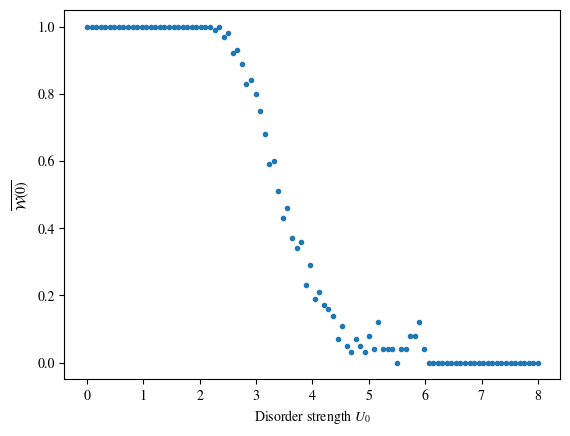

In [5]:
#Numerical disorder averaging NHSSH

L = 20 # in the thesis, the size has been set to L=100, but it takes quite a while to run so here we set it to L= 20
v = 1
w = 1.0
d = 1
 
D = np.linspace(0,8,100)
Wmean = np.zeros(len(D))
Wstd = np.zeros(len(D))
 
for k in tqdm(range(len(D))):
    if 2 <= D[k] <= 5:
        Navg = 100
    else:
        Navg = 25
    waarde = np.zeros(Navg)
    for i in range(Navg):
        waarde[i] = PBCNHSSHODIS(L,v,w,d,D[k])
    Wmean[k] = np.mean(waarde)
    Wstd[k] = np.std(waarde)

plt.plot(D,Wmean,'.')
plt.xlabel('Disorder strength $U_0$')
plt.ylabel('$\overline{\mathcal{W}(0)}$') 

In [7]:
# L = 100
# v = 1
# w = 1.0
# d = 1
 
# D = np.linspace(0,8,100)
# Wmean = np.zeros(len(D))
# Wstd = np.zeros(len(D))

## Calculating the self-consistency equation for a few iterations of the disorder-averaged spectral winding number

\begin{equation*}
    \overline{\mathcal{W}^{(n)}_\pm(0)}=\int\frac{dq}{2\pi i}\text{tr}\left\{\left[\prod_{j=1}^n\left(1-\Sigma_0^{(n-j-1)}\right)^{-1}\right]G_0^{(0)}(q)(\boldsymbol{\alpha}\cdot\boldsymbol{\sigma})\right\}.
\end{equation*}

with the self-energy and disorder-averaged Green's function being given by 

\begin{equation*}
    \Sigma_E^{(n)}(k) = -U_0^2 n_i \int \frac{d q}{2\pi} \overline{G^{(n-1)}_E(q)},
\end{equation*}
\begin{equation*}
    \overline{G_E^{(n)}(k)} = \left[ 1 - \Sigma^{(n)}_E(k) \right]^{-1} \overline{G^{(n-1)}_{E}(k)},
\end{equation*}

In [6]:
#Self consistentency equation. 

#parameters and sign functions
v = np.array([1, 0.5, -1])
g = np.array([1, 2, 1])

Mp=v+1
Mm=v-1
Spp=np.sign(g+Mp)
Spm=np.sign(g-Mp)
Smp=np.sign(g+Mm)
Smm=np.sign(g-Mm)
ni= 0.025 #impurity density
U = np.linspace(0,15) #disorder strength

N=10 #Order of iteration 
Wp=np.zeros([len(v), len(U), N-1])
Wm=np.zeros([len(v), len(U), N-1])

#G0 integral
IGp=np.zeros([len(v), 2,2])
IGm=np.zeros([len(v), 2,2])

for i in range(len(v)):
    IGp[i,:,:]=0.5*np.array([[0,-Spp[i]],[Spm[i],0]])
    IGm[i,:,:]=0.5*np.array([[0,-Smp[i]],[Smm[i],0]])

#first order self energy
Zp0=np.zeros([len(v), len(U), 2, 2])
Zm0=np.zeros([len(v), len(U), 2, 2])

for gg in range(len(v)):
    for i in range(len(U)):
        Zp0[gg,i,:,:]=-U[i]**2*ni*IGp[gg,:,:]
        Zm0[gg,i,:,:]=-U[i]**2*ni*IGm[gg,:,:]

plyx=np.array([[0,-1],[1,0]])   

#Winding plus
Gp=np.zeros([len(v), N, len(U), 2, 2])
for gg in range(len(v)):
    for i in range(len(U)):
        Gp[gg,0,i,:,:] = IGp[gg,:,:]
        
Zp = np.zeros([len(v), N, len(U), 2, 2])
Zp[:,0,:,:,:] = Zp0

#iterate
for gg in range(len(v)):
    for j in range(1,N):
        for k in range(len(U)):
            Gp[gg,j,k,:,:]=np.matmul(np.linalg.inv(np.array([[1,0],[0,1]])-Zp[gg,j-1,k,:,:]),Gp[gg,j-1,k,:,:])
            Zp[gg,j,k,:,:]=-U[k]**2*ni*Gp[gg,j,k,:,:]
            Wp[gg,k,j-1]=np.trace(np.matmul(Gp[gg,j,k,:,:],plyx))
        
#Winding minus
Gm = np.zeros([len(v), N, len(U), 2, 2])
for gg in range(len(v)):
    for i in range(len(U)):
        Gm[gg, 0, i, :, :] = IGm[gg,:,:]
    
Zm=np.zeros([len(v), N, len(U), 2, 2])
Zm[:,0,:,:,:] = Zm0

#iterate 
for gg in range(len(v)):
    for j in range(1,N):
        for k in range(len(U)):
            Gm[gg,j,k,:,:]=np.matmul(np.linalg.inv(np.array([[1,0],[0,1]])-Zm[gg,j-1,k,:,:]),Gm[gg,j-1,k,:,:])
            Zm[gg,j,k,:,:]=-U[k]**2*ni*Gm[gg,j,k,:,:]
            Wm[gg,k,j-1]=-np.trace(np.matmul(Gm[gg,j,k,:,:],plyx))

## Plotting the analytical results, calculated to a few iterations in the SCBA, and the fully numerical for disorder-averaged spectral winding numbers

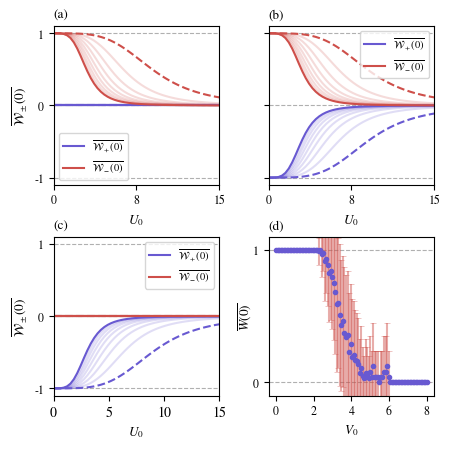

In [7]:
fig, ax= plt.subplots(2,2, figsize=(4.6,4.6))

fz = 9.5
ft = 8.5

for vv in range(2):
    for i in range(0,N-1):
        if i == 0:
            ax[0,vv].plot(U, Wp[vv,:, i].real, ls = "--", c= "#6859d1ff", alpha= 1);
            ax[0,vv].plot(U, Wm[vv,:, i].real, ls = "--", c= "#ce4f4aff", alpha= 1);
        elif i == N-2:
            ax[0,vv].plot(U, Wp[vv,:, i].real, c= "#6859d1ff", alpha= 1, label = "$\overline{\mathcal{W}_+(0)}$");
            ax[0,vv].plot(U, Wm[vv,:, i].real, c= "#ce4f4aff", alpha= 1, label = "$\overline{\mathcal{W}_-(0)}$");
        else:
            ax[0,vv].plot(U, Wp[vv,:, i].real, c= "#6859d1ff", alpha= 0.2);
            ax[0,vv].plot(U, Wm[vv,:, i].real, c= "#ce4f4aff", alpha= 0.2);
    ax[0,vv].legend(fontsize = ft-1)

vv = 2 
for i in range(0,N-1):
    if i == 0:
        ax[1,0].plot(U, Wp[vv,:, i].real, ls = "--", c= "#6859d1ff", alpha= 1);
        ax[1,0].plot(U, Wm[vv,:, i].real, ls = "--", c= "#ce4f4aff", alpha= 1);
    elif i == N-2:
        ax[1,0].plot(U, Wp[vv,:, i].real, c= "#6859d1ff", alpha= 1, label = "$\overline{\mathcal{W}_+(0)}$");
        ax[1,0].plot(U, Wm[vv,:, i].real, c= "#ce4f4aff", alpha= 1, label = "$\overline{\mathcal{W}_-(0)}$");
    else:
        ax[1,0].plot(U, Wp[vv,:, i].real, c= "#6859d1ff", alpha= 0.2);
        ax[1,0].plot(U, Wm[vv,:, i].real, c= "#ce4f4aff", alpha= 0.2);
ax[1,0].legend(fontsize = ft-1)


ax[1,1].errorbar(D, Wmean.real, yerr=Wstd.real, fmt='.', color='#6859d1ff', capsize=2, capthick=0.5, ecolor='#ce4f4a77')

# ax[1,1].axvline(3.5, ls="--", c = "k", alpha= 0.8)

for i in range(2):
    ax[0,i].grid(True, linestyle="--", axis="y")
    ax[1,i].grid(True, linestyle="--", axis="y")
    
xtik = np.linspace(np.min(U), np.max(U), 3)
ytik = np.linspace(-1, 1, 3)
xlab = [f"{xtik[i]:.0f}" for i in range(len(xtik))]
ylab = [f"{ytik[i]:.0f}" for i in range(len(ytik))]

xtik2 = np.linspace(np.min(D), np.max(D), 5)
xlab2 = [f"{xtik2[i]:.0f}" for i in range(len(xtik2))]

    
for axs in ax[0,:]:
    axs.set_xticks(xtik, xlab, fontsize=ft)
    axs.set_yticks(ytik, ylab, fontsize=ft)
    
for axs in ax[1,:]:
    axs.set_yticks(ytik, ylab, fontsize=ft)

ax[1,1].set_xticks(xtik2, xlab2, fontsize=ft)
    
for vv in range(2):
    ax[0,vv].set_xlabel("$U_0$",fontsize = fz);

    ax[0,vv].set_xlim(np.min(U), np.max(U))
    ax[0,vv].set_ylim(-1.1, 1.1)

ax[1,0].set_ylim(-1.1, 1.1)
ax[1,1].set_ylim(-0.1, 1.1)


ax[1,0].set_xlim(np.min(U), np.max(U))


ax[0,0].set_ylabel("$\overline{\mathcal{W}_\pm(0)}$",fontsize = fz);

ax[0,1].tick_params(axis='y', labelleft=False)

    
ax[1,0].set_ylabel("$\overline{\mathcal{W}_\pm(0)}$",fontsize = fz);
ax[1,0].set_xlabel("$U_0$",fontsize = fz);

ax[1,1].set_ylabel("$\overline{W(0)}$",fontsize = fz, labelpad = -1);
ax[1,1].set_xlabel("$V_0$",fontsize = fz);



# Add figure labels
dicts={"(a)": ax[0,0], "(b)": ax[0,1], "(c)": ax[1,0], "(d)": ax[1,1]}

for key, axs in dicts.items():
    axs.set_title(key, loc='left', fontsize=fz)
    
plt.tight_layout(w_pad = 0.8, h_pad = -0.5)

# plt.savefig("NHQFTWpm_Wnum.svg", dpi=600, bbox_inches="tight")



## Calculating the dependence of the spectral winding number on impurity density 

In [11]:
v = 0.5
g = 1

Mp = v+1
Mm = v-1

Smp=np.sign(g+Mm)
Smm=np.sign(g-Mm)

Wm0 = 0.5*(Smp + Smm)

U = np.linspace(0,40,100)

ni = [0.01, 0.025, 0.1]

Wm1 = np.zeros([len(ni), len(U)])

for n in range(len(ni)):
    Wm1[n,:] = 1/(1+(U**2*ni[n]/2)**2*Smm*Smp)*Wm0

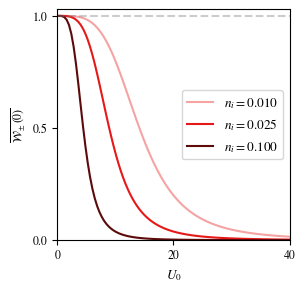

In [12]:
fig, ax= plt.subplots(1, figsize=(3,3))

fz = 9.5
ft = 8.5

c = ["#f5a3a3ff", "#e71818ff", "#5c0a0aff"]

for i in range(3):
    ax.plot(U,Wm1[i,:], c = c[i], label = f"$n_i={ni[i]:.3f}$")

    
xtik = np.linspace(np.min(U), np.max(U), 3)
ytik = np.linspace(0, 1, 3)
xlab = [f"{xtik[i]:.0f}" for i in range(len(xtik))]
ylab = [f"{ytik[i]:.1f}" for i in range(len(ytik))]

ax.set_xticks(xtik, xlab, fontsize=ft)
ax.set_yticks(ytik, ylab, fontsize=ft)
ax.set_ylabel("$\overline{\mathcal{W}_\pm(0)}$",fontsize = ft);
ax.set_xlabel("$U_0$",fontsize = fz);  

ax.set_xlim(np.min(U), np.max(U))
ax.set_ylim(-0, 1.03);

plt.legend(fontsize = fz);

plt.axhline(1, ls="--", c = "gray", alpha=0.4)


# plt.savefig("NHQFTWindImpurity.pdf", dpi=600, bbox_inches="tight")


## Generating some gap-closing examples 

In [455]:
#Gap-closing examples

v, w = 0.5, 1,

g = np.linspace(0,1.75,8)

k = np.linspace(0, 2*np.pi, 2000)

Ep = np.zeros([len(g), len(k)], dtype = np.complex128)
Em = np.zeros([len(g), len(k)], dtype = np.complex128)

for j in range(len(g)):
    Ep[j,:] = np.sqrt(w**2 + v**2 - g[j]**2 + 2*v*w*np.cos(k) - 2*1j*g[j]*w*np.sin(k))
    Em[j,:] = -np.sqrt(w**2 + v**2 - g[j]**2 + 2*v*w*np.cos(k) - 2*1j*g[j]*w*np.sin(k))
    


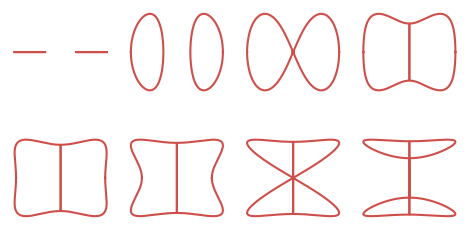

In [461]:
fig, ax= plt.subplots(2, 4, figsize=(4.8,2.4))

for i in range(4):
    ax[0,i].plot(Ep[i,:].real, Ep[i,:].imag, c="#ce4f4aff")
    ax[1,i].plot(Ep[i+4,:].real, Ep[i+4,:].imag, c="#ce4f4aff")
    ax[0,i].plot(Em[i,:].real, Em[i,:].imag, c="#ce4f4aff")
    ax[1,i].plot(Em[i+4,:].real, Em[i+4,:].imag, c="#ce4f4aff")
    ax[0,i].tick_params(axis='y', labelleft=False)
    ax[1,i].tick_params(axis='y', labelleft=False)
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    
for axs in ax[0,:]:
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(False)

for axs in ax[1,:]:
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    
plt.tight_layout(h_pad = 3)

# plt.savefig("NHQFTLineGapPointGaps.svg", dpi=600, bbox_inches="tight")
